# **Extracting textual insights with API**

## 1. **Extracting Data from an API using the Requests Module**

In [29]:
import requests
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
import json
from IPython.display import Markdown, display
import numpy as np
import pandas as pd
import datetime
from datetime import datetime
import time
import tweepy

import regex as re
import nltk
from collections import Counter
from wordcloud import WordCloud

from matplotlib import pyplot as plt

from datetime import datetime
import math


In [3]:
response = requests.get('https://api.github.com/repositories',
                        headers={'Accept': 'application/vnd.github.v3+json'})
print(response.status_code)
print(response.encoding)
print(response.headers['Content-Type'])
print(response.headers['server'])

200
utf-8
application/json; charset=utf-8
GitHub.com


In [7]:
response.headers

{'Date': 'Thu, 11 Feb 2021 08:07:10 GMT', 'Content-Type': 'application/json; charset=utf-8', 'Server': 'GitHub.com', 'Cache-Control': 'public, max-age=60, s-maxage=60', 'Vary': 'Accept, Accept-Encoding, Accept, X-Requested-With, Accept-Encoding', 'ETag': 'W/"2b44a0cea00056e0e9ee543de83bcf14d973573bb77d4f86439e9522e8f31fab"', 'X-GitHub-Media-Type': 'github.v3; format=json', 'Link': '<https://api.github.com/repositories?since=369>; rel="next", <https://api.github.com/repositories{?since}>; rel="first"', 'Access-Control-Expose-Headers': 'ETag, Link, Location, Retry-After, X-GitHub-OTP, X-RateLimit-Limit, X-RateLimit-Remaining, X-RateLimit-Used, X-RateLimit-Reset, X-OAuth-Scopes, X-Accepted-OAuth-Scopes, X-Poll-Interval, X-GitHub-Media-Type, Deprecation, Sunset', 'Access-Control-Allow-Origin': '*', 'Strict-Transport-Security': 'max-age=31536000; includeSubdomains; preload', 'X-Frame-Options': 'deny', 'X-Content-Type-Options': 'nosniff', 'X-XSS-Protection': '1; mode=block', 'Referrer-Policy

In [8]:
print(json.dumps(response.json()[0], indent=2)[:200])

{
  "id": 1,
  "node_id": "MDEwOlJlcG9zaXRvcnkx",
  "name": "grit",
  "full_name": "mojombo/grit",
  "private": false,
  "owner": {
    "login": "mojombo",
    "id": 1,
    "node_id": "MDQ6VXNlcjE=",



In [9]:
response = requests.get('https://api.github.com/search/repositories')
print(response.status_code)

422


In [10]:
response = requests.get('https://api.github.com/search/repositories',
                        params={'q': 'data_science+language:python'},
                        headers={'Accept': 'application/vnd.github.v3.text-match+json'})
print(response.status_code)

200


In [15]:
def printmd(string): 
    display(Markdown(string))  

for item in response.json()['items'][:5]:
    printmd('**' + item['name'] + '**' + ': repository ' +
            item['text_matches'][0]['property'] + ' - \"*' +
            item['text_matches'][0]['fragment'] + '*\" matched with ' + '**' +
            item['text_matches'][0]['matches'][0]['text'] + '**')
    

**data-science-from-scratch**: repository description - "*code for Data Science From Scratch book*" matched with **Data Science**

**data-science-blogs**: repository description - "*A curated list of data science blogs*" matched with **data science**

**data-scientist-roadmap**: repository description - "*Toturial coming with "data science roadmap" graphe.*" matched with **data science**

**galaxy**: repository description - "*Data intensive science for everyone.*" matched with **Data**

**metaflow**: repository description - "*Build and manage real-life data science projects with ease.*" matched with **data science**

In [68]:
response = requests.get(
    'https://api.github.com/repos/pytorch/pytorch/issues/comments')
print('Response Code', response.status_code)
print('Number of comments', len(response.json()))


Response Code 200
Number of comments 30


### Pagination

In [56]:
response.links

{'next': {'url': 'https://api.github.com/repositories/65600975/issues/comments?page=2',
  'rel': 'next'},
 'last': {'url': 'https://api.github.com/repositories/65600975/issues/comments?page=1334',
  'rel': 'last'}}

In [79]:
def get_all_pages(url, params=None, headers=None):
    output_json = []
    response = requests.get(url, params=params, headers=headers)
    if response.status_code == 200:
        output_json = response.json()
        if 'next' in response.links:
            next_url = response.links['next']['url']
            if next_url is not None:
                output_json += get_all_pages(next_url, params, headers)
    return output_json


out = get_all_pages(
    "https://api.github.com/repos/pytorch/pytorch/issues",
    params={
        'since': '2020-07-01T10:00:01Z',
        'sorted': 'created',
        'direction': 'desc'
    },
    headers={'Accept': 'application/vnd.github.v3+json'})
df = pd.DataFrame(out)

In [82]:
pd.set_option('display.max_colwidth', -1) ###
print (df['body'].count())
df[['id','created_at','body']].sample(1)

1500


<ipython-input-82-f492a0b9deec>:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1) ###


id            created_at  \
1290  748089038  2020-11-21T19:39:21Z   

                                                                                                                                                                           body  
1290  Would love to see “GoTorch” implemented to improve upon the awfulness in python. We’d have better tools to debug and explain NNs in Go, and then an actual typed system.

In [84]:
response = requests.head(
    'https://api.github.com/repos/pytorch/pytorch/issues/comments')
print('X-Ratelimit-Limit', response.headers['X-Ratelimit-Limit'])
print('X-Ratelimit-Remaining', response.headers['X-Ratelimit-Remaining'])

# Converting UTC time to human-readable format
print(
    'Rate Limits reset at',
    datetime.datetime.fromtimestamp(int(
        response.headers['X-RateLimit-Reset'])).strftime('%c'))

X-Ratelimit-Limit 60
X-Ratelimit-Remaining 0
Rate Limits reset at Thu Feb 11 10:52:31 2021


In [86]:
def handle_rate_limits(response):
    now = datetime.now()
    reset_time = datetime.fromtimestamp(
        int(response.headers['X-RateLimit-Reset']))
    remaining_requests = response.headers['X-Ratelimit-Remaining']
    remaining_time = (reset_time - now).total_seconds()
    intervals = remaining_time / (1.0 + int(remaining_requests))
    print('Sleeping for', intervals)
    time.sleep(intervals)
    return True

In [88]:
retry_strategy = Retry(
    total=5,
    status_forcelist=[500, 503, 504],
    backoff_factor=1
)

retry_adapter = HTTPAdapter(max_retries=retry_strategy)

http = requests.Session()
http.mount("https://", retry_adapter)
http.mount("http://", retry_adapter)

response = http.get('https://api.github.com/search/repositories',
                   params={'q': 'data_science+language:python'})

for item in response.json()['items'][:5]:
    print (item['name'])

data-science-from-scratch
data-science-blogs
data-scientist-roadmap
galaxy
metaflow


In [89]:
retry_strategy = Retry(
    total=5,
    status_forcelist=[500, 503, 504],
    backoff_factor=1
)

retry_adapter = HTTPAdapter(max_retries=retry_strategy)

http = requests.Session()
http.mount("https://", retry_adapter)
http.mount("http://", retry_adapter)

def get_all_pages(url, param=None, header=None):
    output_json = []
    response = http.get(url, params=param, headers=header)
    if response.status_code == 200:
        output_json = response.json()
        if 'next' in response.links:
            next_url = response.links['next']['url']
            if (next_url is not None) and (handle_rate_limits(response)): 
                output_json += get_all_pages(next_url, param, header)
    return output_json

## 2. **Extracting Twitter Data with Tweepy**

In [2]:
app_api_key = ''
app_api_secret_key = ''

auth = tweepy.AppAuthHandler(app_api_key, app_api_secret_key)
api = tweepy.API(auth)

print('API host', api.host)
print('API version', api.api_root)

API host api.twitter.com
API version /1.1


In [3]:
pd.set_option('display.max_colwidth', None)


search_term = 'cryptocurrency'
tweets = tweepy.Cursor(api.search,
                       q=search_term,
                       lang='en').items(100)

retrieved_tweets = [tweet._json for tweet in tweets]

df = pd.json_normalize(retrieved_tweets)
df[['text']].sample(5)


text
21  RT @latokens: Join the @universeecoin Airdrop to get a share of 5 million $UNIS coins. 💰\n\n✅ Buy minimum 20 UNIS tokens and get a 30% assure…
56    RT @MaradesaG: We are human not cow, we demand for justice not death. You can’t kill us all. Our blood will seek revenge on you to your thi…
4    RT @RhyseHardy: Morning Celsians and all cryptocurrency followers, to celebrate surpassing $7,000,000 I’m giving away 50 CEL tokens. \nFollo…
75  RT @Investingcom: *India finally bans cryptocurrencies, gives investors six months to liquidate their assets - https://t.co/0lRSMzbtDn \n\n#B…
65    RT @MaradesaG: We are human not cow, we demand for justice not death. You can’t kill us all. Our blood will seek revenge on you to your thi…

In [4]:
api = tweepy.API(auth,
                 wait_on_rate_limit=True,
                 wait_on_rate_limit_notify=True,
                 retry_count=5,
                 retry_delay=10)

search_term = 'cryptocurrency OR crypto -filter:retweets'

tweets = tweepy.Cursor(api.search,
                       q=search_term,
                       lang='en',
                       tweet_mode='extended',
                       count=30).items(12000)

retrieved_tweets = [tweet._json for tweet in tweets]

df = pd.json_normalize(retrieved_tweets)
print('Number of retrieved tweets', len(df))
df[['created_at', 'full_text', 'entities.hashtags']].sample(2)


Number of retrieved tweets 12000


created_at  \
3852  Sat Feb 13 06:00:52 +0000 2021   
2945  Sat Feb 13 06:27:22 +0000 2021   

                                                                                                                                                                                    full_text  \
3852  South Korean Court Orders Bithumb to Compensate Users for an Accidental BTC Withdrawal Case in 2018 – Bitcoin News CRYPTO CRYPTO NEWS - https://t.co/cCq6kcPNjZ https://t.co/Zv9DwIGKPm   
2945                                          ETH VS USD: Time to Watch: Bybite Exchange: Crypto for BYBIT:ETHUSDT by Sunstorminvest #ETHUSDT https://t.co/KhAih7MPdo https://t.co/MSBtWxkQjr   

                               entities.hashtags  
3852                                          []  
2945  [{'text': 'ETHUSDT', 'indices': [87, 95]}]

In [6]:
def extract_entities(entity_list):
    entities = set()
    if len(entity_list) != 0:
        for item in entity_list:
            for key,value in item.items():
                if key == 'text':
                    entities.add(value.lower())
    return list(entities)


<AxesSubplot:>

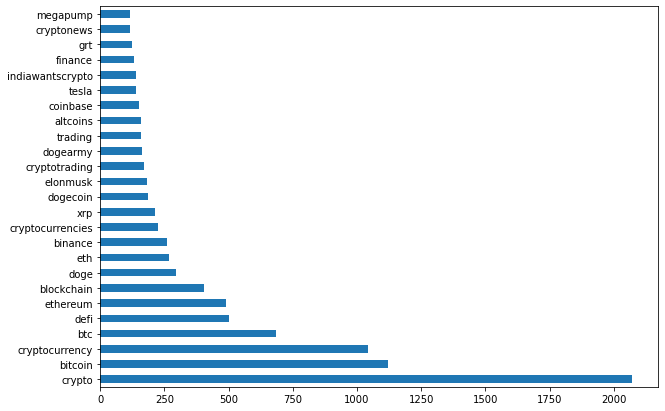

In [15]:
df['Entities'] = df['entities.hashtags'].apply(extract_entities)
pd.Series(np.concatenate(df['Entities'])).value_counts()[:25].plot(kind='barh', figsize=(10,7))

## Extracting data from a user's timeline

In [17]:
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

tweets = tweepy.Cursor(api.user_timeline,
                       screen_name='MercedesAMGF1',
                       lang="en",
                       tweet_mode='extended',
                       count=100).items(5000)

retrieved_tweets = [tweet._json for tweet in tweets]
df = pd.json_normalize(retrieved_tweets)
print ('Number of retrieved tweets ', len(df))

Number of retrieved tweets  3213


In [18]:
def get_user_timeline(screen_name):
    api = tweepy.API(auth,
                     wait_on_rate_limit=True,
                     wait_on_rate_limit_notify=True)
    tweets = tweepy.Cursor(api.user_timeline,
                           screen_name=screen_name,
                           lang="en",
                           tweet_mode='extended',
                           count=200).items()
    retrieved_tweets = [tweet._json for tweet in tweets]
    df = pd.json_normalize(retrieved_tweets)
    df = df[~df['retweeted_status.id'].isna()]
    return df

In [19]:
df_mercedes = get_user_timeline('MercedesAMGF1')
print ('Number of Tweets from Mercedes', len(df_mercedes))
df_ferrari = get_user_timeline('ScuderiaFerrari')
print ('Number of Tweets from Ferrari', len(df_ferrari))

Number of Tweets from Mercedes 242
Number of Tweets from Ferrari 126


In [21]:

stopwords = set(nltk.corpus.stopwords.words('english'))
RE_LETTER = re.compile(r'\b\p{L}{2,}\b')

def tokenize(text):
    return RE_LETTER.findall(text)

def remove_stop(tokens):
    return [t for t in tokens if t.lower() not in stopwords]

pipeline = [str.lower, tokenize, remove_stop]

def prepare(text):
    tokens = text
    for transform in pipeline:
        tokens = transform(tokens)
    return tokens

def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")

In [22]:
def wordcloud_blueprint(df, colName, max_words, num_stopwords):
    # Step 1: Convert input text column into tokens
    df['tokens'] = df[colName].map(prepare)
    
    # Step 2: Determine the frequency of each of the tokens
    freq_df = count_words(df)
    
    # Step 3: Generate the wordcloud using the frequencies controlling for stopwords
    wordcloud(freq_df['freq'], max_words, stopwords=freq_df.head(num_stopwords).index)

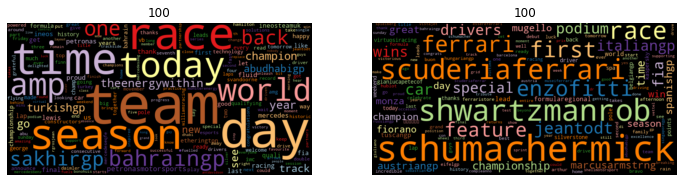

In [28]:
plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1)  ###
wordcloud_blueprint(df_mercedes, 'full_text',
          max_words=100,
          num_stopwords=5)

plt.subplot(1, 2, 2)  ###
wordcloud_blueprint(df_ferrari, 'full_text',
          max_words=100,
          num_stopwords=5)

## Extracting data from the streaming API

In [30]:
class FileStreamListener(tweepy.StreamListener):
    
    def __init__(self, max_tweets=math.inf):
        self.num_tweets = 0
        self.TWEETS_FILE_SIZE = 10
        self.num_files = 0
        self.tweets = []
        self.max_tweets = max_tweets      
    
    def on_data(self, data):
        while (self.num_files * self.TWEETS_FILE_SIZE < self.max_tweets):
            self.tweets.append(json.loads(data))
            self.num_tweets += 1
            if (self.num_tweets < self.TWEETS_FILE_SIZE):
                return True
            else:
                filename = 'Tweets_' + str(datetime.now().time()) + '.txt'
                print (self.TWEETS_FILE_SIZE, 'Tweets saved to', filename)
                file = open(filename, "w")
                json.dump(self.tweets, file)
                file.close()
                self.num_files += 1
                self.tweets = []
                self.num_tweets = 0
                return True
        return False
        
    def on_error(self, status_code):
        if status_code == 420:
            print ('Too many requests were made, please stagger requests')
            return False
        else:
            print ('Error {}'.format(status_code))
            return False

In [31]:
user_access_token = 'YOUR_USER_ACCESS_TOKEN_HERE'
user_access_secret = 'YOUR_USER_ACCESS_SECRET_HERE'

auth = tweepy.OAuthHandler(app_api_key, app_api_secret_key)
auth.set_access_token(user_access_token, user_access_secret)
api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [32]:
fileStreamListener = FileStreamListener(20)
fileStream = tweepy.Stream(auth=api.auth,
                           listener=fileStreamListener,
                           tweet_mode='extended')
fileStream.filter(track=['cryptocurrency'])

Error 401


In [ ]:
fileStreamListener = FileStreamListener(20)
fileStream = tweepy.Stream(auth=api.auth,
                           listener=fileStreamListener,
                           tweet_mode='extended')
fileStream.filter(track=['cryptocurrency'])

In [ ]:
df = pd.json_normalize(json.load(open('Tweets_01:01:36.656960.txt')))
df.head(2)

## Wikipedia API

In [38]:
!pip install Wikipedia-API
import wikipediaapi

In [39]:
wiki_wiki = wikipediaapi.Wikipedia(
        language='en',
        extract_format=wikipediaapi.ExtractFormat.WIKI
)

p_wiki = wiki_wiki.page('Cryptocurrency')
print (p_wiki.text[:200], '....')

A cryptocurrency (or crypto currency or crypto for short) is a digital asset designed to work as a medium of exchange wherein individual coin ownership records are stored in a ledger existing in a for ....
